In [1]:
%pip install unidecode
%pip install xlrd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 6.3 MB/s eta 0:00:00


In [3]:
import re, io, unicodedata, requests, pandas as pd
import numpy as np

# ---------- Utilidades ----------
def normalize_colnames(cols):
    out = []
    for c in cols:
        c = str(c)
        c = ''.join(ch for ch in unicodedata.normalize('NFKD', c) if not unicodedata.combining(ch))
        c = re.sub(r'\s+', ' ', c).strip().lower()
        c = re.sub(r'[^a-z0-9]+', '_', c)
        c = re.sub(r'_+', '_', c).strip('_')
        out.append(c)
    return out

# Sinónimos hacia nombres estándar
SYN_MAP = {
    r"^(depto|dep|departamento|dpto)$": "departamento",
    r"^(municipio|ciudad|mpio|municpio|munici?p[io])$": "municipio",  # tolera typos
    r"^(codigo_dane|cod_dane|codigo_dane_municipio|codigodane|coddane)$": "codigo_dane",
    r"^(arma_s?_?medios?|armas?_?medios?|arma|medio|armamedio|arma_emple.*)$": "arma_medio",
    r"^(fecha|fecha_hecho|fecha_del_hecho|fec_hecho)$": "fecha_hecho",
    r"^(genero|sexo)$": "genero",
    r"^(agrupa_edad_persona|grupo_edad|rango_edad|edad_grupo|grupo_etario|agrupa_edad)$": "agrupa_edad_persona",
    r"^(cantidad|total|nro_casos|num_casos|casos)$": "cantidad",
}

# Columnas finales que queremos conservar
STANDARD_ORDER = [
    "departamento","municipio","codigo_dane",
    "arma_medio","fecha_hecho","genero",
    "agrupa_edad_persona","cantidad","ANIO","DELITO"
]

def fetch_excel(url: str) -> bytes:
    r = requests.get(url, timeout=90)
    r.raise_for_status()
    return r.content

def detect_header_row(pre_df: pd.DataFrame, max_scan_rows: int = 40) -> int:
    keys = ["depart","munic","codigo","dane","arma","medio","fecha","genero","sexo","edad","agrupa","cantidad","total"]
    best_row, best_hits = 0, -1
    for i in range(min(max_scan_rows, len(pre_df))):
        row = pre_df.iloc[i].astype(str).fillna("").tolist()
        text = " | ".join(row).lower()
        hits = sum(k in text for k in keys)
        if hits > best_hits:
            best_hits = hits
            best_row = i
    return best_row

def read_excel_smart(content: bytes, url: str) -> pd.DataFrame:
    # Leer unas filas sin header para detectar
    pre = pd.read_excel(io.BytesIO(content), header=None, nrows=60, engine=None)
    hdr = detect_header_row(pre)
    try:
        df = pd.read_excel(io.BytesIO(content), header=hdr, engine=None)
    except Exception:
        ext = url.lower().split("?")[0]
        engine = "xlrd" if ext.endswith(".xls") else None
        df = pd.read_excel(io.BytesIO(content), header=hdr, engine=engine)
    df = df.loc[:, ~df.columns.astype(str).duplicated()]
    return df

# --- NUEVO: cortar pie desde 'TOTAL' (incluyéndolo) ---
def cut_footer_strict(df: pd.DataFrame) -> pd.DataFrame:
    # Texto por fila
    row_text = df.fillna("").astype(str).agg(" ".join, axis=1).str.lower()
    # 1) buscar 'TOTAL' exacto o con ':' o espacio
    m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)
    idx = np.where(m_total.values)[0]
    cut_at = int(idx[0]) if len(idx) > 0 else None
    # 2) si no hay 'TOTAL', cortar en otros triggers típicos
    if cut_at is None:
        m_trig = row_text.str.contains(r"(fuente|siedco|dijin|elaborado:|revisado:|autorizado:)")
        idx2 = np.where(m_trig.values)[0]
        if len(idx2) > 0:
            cut_at = int(idx2[0])
    if cut_at is not None:
        df = df.iloc[:cut_at, :].copy()
    # quitar filas totalmente vacías
    return df.replace(r"^\s*$", pd.NA, regex=True).dropna(how="all")

def apply_synonyms(df: pd.DataFrame) -> pd.DataFrame:
    cols = normalize_colnames(df.columns)
    df = df.copy()
    df.columns = cols
    mapped = []
    for c in df.columns:
        m = None
        for patt, tgt in SYN_MAP.items():
            if re.fullmatch(patt, c):
                m = tgt; break
        mapped.append(m if m else c)
    df.columns = mapped
    return df

def add_year_and_delito(df: pd.DataFrame, url: str, delito: str) -> pd.DataFrame:
    df = df.copy()
    yrs = re.findall(r"(20\d{2})", url)
    if yrs:
        df["ANIO"] = int(yrs[-1])
    elif "fecha_hecho" in df.columns:
        fechas = pd.to_datetime(df["fecha_hecho"], errors="coerce", dayfirst=True)
        df["ANIO"] = fechas.dt.year
    else:
        df["ANIO"] = pd.NA
    df["DELITO"] = delito.upper()
    return df

# --- NUEVO: eliminar columnas ruido y dejar solo estándar + DELITO ---
def drop_noise_columns(df: pd.DataFrame) -> pd.DataFrame:
    # eliminar 'unnamed_*'
    df = df.loc[:, ~df.columns.str.match(r"^unnamed_\d+$", case=False)].copy()
    # eliminar columnas totalmente vacías
    empty_cols = [c for c in df.columns if df[c].isna().all() or (df[c].astype(str).str.strip() == "").all()]
    df.drop(columns=empty_cols, inplace=True, errors="ignore")
    # eliminar columnas de origen llamadas 'delito' o 'delitos' (pero conservar la nuestra 'DELITO')
    drop_src = [c for c in df.columns if c.lower() in ("delito", "delitos") and c != "DELITO"]
    df.drop(columns=drop_src, inplace=True, errors="ignore")
    # ordenar y limitar a las columnas estándar existentes
    keep_existing = [c for c in STANDARD_ORDER if c in df.columns]
    return df[keep_existing]

# ---------- Todas las URLs por delito ----------
delitos = {
    "ABIGEATO": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20a%20cabezas%20de%20ganado2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20cabezas%20de%20ganado.._0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/abigeato.xls_2.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/abigeato_6.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/abigeato_2020.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/abigeato_2019_3.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/abigeato_2018_2.xlsx",
    ],
    "AMENAZAS": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Amenazas2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/amenzas..xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/amenazas_13.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/amenazas_11.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/amenazas_2020.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/amenazas_2019_1.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/amenazas_2018_1.xlsx",
    ],
    "DELITOS SEXUALES": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Delitos%20sexuales2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/delitos%20sexuales.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/delitos_sexuales_11.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/delitos_sexuales_9.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/delitos_sexuales_2020.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/delitos_sexuales_2019_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/delitos_sexuales_2018_0.xlsx",
    ],
    "EXTORSION": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Extorsi%C3%B3n2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/extorsion_11.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/extorsion_11.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/extorsion_9.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/extorsion_2020_1.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/extorsion_2019_2.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/extorsion_2018_3.xlsx",
    ],
    "HOMICIDIOS": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Homicidio%20Intencional2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidio%20intencional_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Homicidio%20Intencional%202022.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidios2022.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Homicidio%20Intencional%202021.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Homicidio%20Intencional%202020.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Homicidio%20Intencional%202019.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Homicidio%20Intencional%202018.xlsx",
    ],
    "HOMICIDIOS EN ACCIDENTES DE TRANSITO": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Homicidios%20en%20accidente%20de%20tr%C3%A1nsito2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidios%20en%20accidente%20de%20transito....xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidios_en_accidente_de_transito_11.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidios_en_accidente_de_transito_9.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidios_accidente_de_transito_2020_2.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidios_en_accidente_de_transito_2019.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidios_en_accidente_de_transito_2018_1.xlsx",
    ],
    "HURTO A PERSONAS": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20a%20personas2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20a%20personas.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_personas_17.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_personas_9.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_personas_2020_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_personas_2019_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_personas_2018_1.xlsx",
    ],
    "HURTO A RESIDENCIAS": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20a%20residencias2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20a%20residencias....xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_residencias_4.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_residencias_5.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_residencias_2020.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_residencias_2019_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_residencias_2018_1.xlsx",
    ],
    "HURTO DE AUTOMOTORES": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20automotores2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20automotores....xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_automotores_4.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_automotores_5.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_automotores_2020_1.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_automotores_2019_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_automotores_2018_1.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_automotores_2018_2.xlsx",
    ],
    "HURTO DE MOTOCICLETAS": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20a%20motocicletas2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20a%20motocicletas....xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_motocicletas_7.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_motocicletas_5.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_motocicletas_2020.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_motocicletas_2019_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_motocicletas_2018_0.xlsx",
    ],
    "HURTOS A ENTIDADES COMERCIALES": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20a%20comercio2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20a%20comercio..._0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_comercio_11.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_comercio_9.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_comercio_2020.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_comercio_2019_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_comercio_2018_1.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_motocicletas_2018_0.xlsx",
    ],
    "HURTOS A ENTIDADES FINANCIERAS": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20a%20entidades%20Financieras2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20entidades%20financieras.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_entidades_financieras_11.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_entidades_financieras_9.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_entidades_financieras_2020.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_entidades_financieras_2019_3.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_entidades_financieras_2018_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_entidades_financieras_2018_3.xlsx",
    ],
    "LESIONES EN ACCIDENTES DE TRANSITO": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Lesiones%20en%20accidente%20de%20tr%C3%A1nsito2024_2.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones%20en%20accidente%20de%20transito....xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_en_accidente_de_transito_7.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_en_accidente_de_transito_5.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_en_accidente_de_transito_2020_1.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_en_accidente_de_transito_2019_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_en_accidente_de_transito_2018_1.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_en_accidente_de_transito_2018_0.xlsx",
    ],
    "LESIONES PERSONALES": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Lesiones%20personales2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones%20personales..._0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_personales_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_personales_5.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_personales_2020.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_personales_2019_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_personales_2018_0.xlsx",
    ],
    "PIRATERIA TERRESTRE": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20pirater%C3%ADa%20terrestre2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20pirateria%20terrestre_1.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_pirateria_terrestre_11.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_pirateria_terrestre_9.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/pirateria_terrestre_2020_1.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_entidades_financieras_2020_0.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/pirateria_terrestre_2019_3.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/pirateria_terrestre_2018_2.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/pirateria_terrestre_2018_1.xlsx",
    ],
    "SECUESTRO": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Secuestro2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/secuestro..._0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/secuestro_11.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/secuestro_9.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/secuestro_2020.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/secuestro_2019_3.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/secuestro_2018_3.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/secuestro_2018_2.xlsx",
    ],
    "TERRORISMO": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Terrorismo2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_4.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_11.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_9.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_2020_1.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_2020_0.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_2019_2.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_2018_2.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_2018_0.xlsx",
    ],
    "VIOLENCIA INTRAFAMILIAR": [
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/Violencia%20intrafamiliar2024_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia%20intrafamiliar....xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia_intrafamiliar_12.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia_intrafamiliar_10.xls",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia_intrafamiliar_2020.xls_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia_intrafamiliar_2019_0.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia_intrafamiliar_2018_1.xlsx",
        "https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia_intrafamiliar_2018_0.xlsx",
    ],
}

# ---------- Procesamiento ----------
frames = []
for delito, urls in delitos.items():
    for url in urls:
        try:
            print(f"Descargando: {delito} -> {url}")
            content = fetch_excel(url)
            df = read_excel_smart(content, url)
            df = cut_footer_strict(df)             # <<< CORTA pie desde TOTAL
            df = apply_synonyms(df)                # <<< Normaliza nombres
            df = add_year_and_delito(df, url, delito)  # <<< Añade ANIO y DELITO
            if "cantidad" in df.columns:
                df["cantidad"] = pd.to_numeric(df["cantidad"], errors="coerce")
            df = drop_noise_columns(df)            # <<< Quita ruido y deja solo estándar + DELITO
            frames.append(df)
        except Exception as e:
            print(f"** Error con {url}: {e}")

if frames:
    data_delitos = pd.concat(frames, ignore_index=True).dropna(how="all")
    print("\n=== RESUMEN DATASET TOTAL ===")
    print("Filas:", data_delitos.shape[0], " Columnas:", data_delitos.shape[1])
    print("\nTipos de datos:\n", data_delitos.dtypes)
    print("\nPrimeras filas:\n", data_delitos.head(5))
    # Guardar CSV
    data_delitos.to_csv("delitos_unificado.csv", index=False, encoding="utf-8-sig")
    print('\nArchivo guardado: delitos_unificado.csv')
else:
    print("No se pudo construir el dataset combinado (todas las lecturas fallaron).")

Descargando: ABIGEATO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20a%20cabezas%20de%20ganado2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: ABIGEATO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20cabezas%20de%20ganado.._0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: ABIGEATO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/abigeato.xls_2.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: ABIGEATO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/abigeato_6.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: ABIGEATO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/abigeato_2020.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: ABIGEATO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/abigeato_2019_3.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: ABIGEATO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/abigeato_2018_2.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: AMENAZAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Amenazas2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: AMENAZAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/amenzas..xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: AMENAZAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/amenazas_13.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: AMENAZAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/amenazas_11.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: AMENAZAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/amenazas_2020.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: AMENAZAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/amenazas_2019_1.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: AMENAZAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/amenazas_2018_1.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: DELITOS SEXUALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Delitos%20sexuales2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: DELITOS SEXUALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/delitos%20sexuales.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: DELITOS SEXUALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/delitos_sexuales_11.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: DELITOS SEXUALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/delitos_sexuales_9.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: DELITOS SEXUALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/delitos_sexuales_2020.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: DELITOS SEXUALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/delitos_sexuales_2019_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: DELITOS SEXUALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/delitos_sexuales_2018_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: EXTORSION -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Extorsi%C3%B3n2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: EXTORSION -> https://www.policia.gov.co/sites/default/files/delitos-impacto/extorsion_11.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: EXTORSION -> https://www.policia.gov.co/sites/default/files/delitos-impacto/extorsion_11.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: EXTORSION -> https://www.policia.gov.co/sites/default/files/delitos-impacto/extorsion_9.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: EXTORSION -> https://www.policia.gov.co/sites/default/files/delitos-impacto/extorsion_2020_1.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: EXTORSION -> https://www.policia.gov.co/sites/default/files/delitos-impacto/extorsion_2019_2.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: EXTORSION -> https://www.policia.gov.co/sites/default/files/delitos-impacto/extorsion_2018_3.xlsx
** Error con https://www.policia.gov.co/sites/default/files/delitos-impacto/extorsion_2018_3.xlsx: HTTPSConnectionPool(host='www.policia.gov.co', port=443): Read timed out.
Descargando: HOMICIDIOS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Homicidio%20Intencional2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HOMICIDIOS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidio%20intencional_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HOMICIDIOS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Homicidio%20Intencional%202022.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HOMICIDIOS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidios2022.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HOMICIDIOS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Homicidio%20Intencional%202021.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HOMICIDIOS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Homicidio%20Intencional%202020.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HOMICIDIOS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Homicidio%20Intencional%202019.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HOMICIDIOS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Homicidio%20Intencional%202018.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HOMICIDIOS EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Homicidios%20en%20accidente%20de%20tr%C3%A1nsito2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HOMICIDIOS EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidios%20en%20accidente%20de%20transito....xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HOMICIDIOS EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidios_en_accidente_de_transito_11.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HOMICIDIOS EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidios_en_accidente_de_transito_9.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HOMICIDIOS EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidios_accidente_de_transito_2020_2.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HOMICIDIOS EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidios_en_accidente_de_transito_2019.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HOMICIDIOS EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/homicidios_en_accidente_de_transito_2018_1.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO A PERSONAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20a%20personas2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO A PERSONAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20a%20personas.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO A PERSONAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_personas_17.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO A PERSONAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_personas_9.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO A PERSONAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_personas_2020_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO A PERSONAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_personas_2019_0.xlsx
** Error con https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_personas_2019_0.xlsx: ('Connection broken: IncompleteRead(6127114 bytes read, 6027835 more expected)', IncompleteRead(6127114 bytes read, 6027835 more expected))
Descargando: HURTO A PERSONAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_personas_2018_1.xlsx
** Error con https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_personas_2018_1.xlsx: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))
Descargando: HURTO A RESIDENCIAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20a%20residencias2024_0.xlsx
** Error con https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20a%20residencias2024_0.xlsx: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by pe

/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO A RESIDENCIAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_residencias_5.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO A RESIDENCIAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_residencias_2020.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO A RESIDENCIAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_residencias_2019_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO A RESIDENCIAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_residencias_2018_1.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE AUTOMOTORES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20automotores2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE AUTOMOTORES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20automotores....xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE AUTOMOTORES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_automotores_4.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE AUTOMOTORES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_automotores_5.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE AUTOMOTORES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_automotores_2020_1.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE AUTOMOTORES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_automotores_2019_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE AUTOMOTORES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_automotores_2018_1.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE AUTOMOTORES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_automotores_2018_2.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE MOTOCICLETAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20a%20motocicletas2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE MOTOCICLETAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20a%20motocicletas....xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE MOTOCICLETAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_motocicletas_7.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE MOTOCICLETAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_motocicletas_5.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE MOTOCICLETAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_motocicletas_2020.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE MOTOCICLETAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_motocicletas_2019_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTO DE MOTOCICLETAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_motocicletas_2018_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES COMERCIALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20a%20comercio2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES COMERCIALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20a%20comercio..._0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES COMERCIALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_comercio_11.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES COMERCIALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_comercio_9.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES COMERCIALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_comercio_2020.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES COMERCIALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_comercio_2019_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES COMERCIALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_comercio_2018_1.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES COMERCIALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_motocicletas_2018_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES FINANCIERAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20a%20entidades%20Financieras2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES FINANCIERAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20entidades%20financieras.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES FINANCIERAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_entidades_financieras_11.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES FINANCIERAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_entidades_financieras_9.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES FINANCIERAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_entidades_financieras_2020.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES FINANCIERAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_entidades_financieras_2019_3.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES FINANCIERAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_entidades_financieras_2018_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: HURTOS A ENTIDADES FINANCIERAS -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_entidades_financieras_2018_3.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Lesiones%20en%20accidente%20de%20tr%C3%A1nsito2024_2.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones%20en%20accidente%20de%20transito....xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_en_accidente_de_transito_7.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_en_accidente_de_transito_5.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_en_accidente_de_transito_2020_1.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_en_accidente_de_transito_2019_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_en_accidente_de_transito_2018_1.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES EN ACCIDENTES DE TRANSITO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_en_accidente_de_transito_2018_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES PERSONALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Lesiones%20personales2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES PERSONALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones%20personales..._0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES PERSONALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_personales_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES PERSONALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_personales_5.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES PERSONALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_personales_2020.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES PERSONALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_personales_2019_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: LESIONES PERSONALES -> https://www.policia.gov.co/sites/default/files/delitos-impacto/lesiones_personales_2018_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: PIRATERIA TERRESTRE -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Hurto%20pirater%C3%ADa%20terrestre2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: PIRATERIA TERRESTRE -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto%20pirateria%20terrestre_1.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: PIRATERIA TERRESTRE -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_pirateria_terrestre_11.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: PIRATERIA TERRESTRE -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_a_pirateria_terrestre_9.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: PIRATERIA TERRESTRE -> https://www.policia.gov.co/sites/default/files/delitos-impacto/pirateria_terrestre_2020_1.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: PIRATERIA TERRESTRE -> https://www.policia.gov.co/sites/default/files/delitos-impacto/hurto_entidades_financieras_2020_0.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: PIRATERIA TERRESTRE -> https://www.policia.gov.co/sites/default/files/delitos-impacto/pirateria_terrestre_2019_3.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: PIRATERIA TERRESTRE -> https://www.policia.gov.co/sites/default/files/delitos-impacto/pirateria_terrestre_2018_2.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: PIRATERIA TERRESTRE -> https://www.policia.gov.co/sites/default/files/delitos-impacto/pirateria_terrestre_2018_1.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: SECUESTRO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Secuestro2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: SECUESTRO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/secuestro..._0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: SECUESTRO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/secuestro_11.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: SECUESTRO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/secuestro_9.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: SECUESTRO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/secuestro_2020.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: SECUESTRO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/secuestro_2019_3.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: SECUESTRO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/secuestro_2018_3.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: SECUESTRO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/secuestro_2018_2.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: TERRORISMO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Terrorismo2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: TERRORISMO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_4.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: TERRORISMO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_11.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: TERRORISMO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_9.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: TERRORISMO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_2020_1.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: TERRORISMO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_2020_0.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: TERRORISMO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_2019_2.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: TERRORISMO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_2018_2.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: TERRORISMO -> https://www.policia.gov.co/sites/default/files/delitos-impacto/terrorismo_2018_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: VIOLENCIA INTRAFAMILIAR -> https://www.policia.gov.co/sites/default/files/delitos-impacto/Violencia%20intrafamiliar2024_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: VIOLENCIA INTRAFAMILIAR -> https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia%20intrafamiliar....xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: VIOLENCIA INTRAFAMILIAR -> https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia_intrafamiliar_12.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: VIOLENCIA INTRAFAMILIAR -> https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia_intrafamiliar_10.xls


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: VIOLENCIA INTRAFAMILIAR -> https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia_intrafamiliar_2020.xls_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: VIOLENCIA INTRAFAMILIAR -> https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia_intrafamiliar_2019_0.xlsx
** Error con https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia_intrafamiliar_2019_0.xlsx: HTTPSConnectionPool(host='www.policia.gov.co', port=443): Read timed out.
Descargando: VIOLENCIA INTRAFAMILIAR -> https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia_intrafamiliar_2018_1.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)


Descargando: VIOLENCIA INTRAFAMILIAR -> https://www.policia.gov.co/sites/default/files/delitos-impacto/violencia_intrafamiliar_2018_0.xlsx


/tmp/ipython-input-2597040796.py:70: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  m_total = row_text.str.contains(r"(^|\s)total(\s|:|$)", regex=True)



=== RESUMEN DATASET TOTAL ===
Filas: 2883028  Columnas: 10

Tipos de datos:
 departamento            object
municipio               object
codigo_dane            float64
arma_medio              object
fecha_hecho             object
genero                  object
agrupa_edad_persona     object
cantidad               float64
ANIO                     int64
DELITO                  object
dtype: object

Primeras filas:
   departamento      municipio  codigo_dane                   arma_medio  \
0    ANTIOQUIA          Amagá    5030000.0  ARMA BLANCA / CORTOPUNZANTE   
1    ANTIOQUIA        Barbosa    5079000.0  ARMA BLANCA / CORTOPUNZANTE   
2    ANTIOQUIA          Maceo    5425000.0  ARMA BLANCA / CORTOPUNZANTE   
3    ANTIOQUIA          Maceo    5425000.0  ARMA BLANCA / CORTOPUNZANTE   
4    ANTIOQUIA  Puerto Berrío    5579000.0  ARMA BLANCA / CORTOPUNZANTE   

           fecha_hecho     genero agrupa_edad_persona  cantidad  ANIO  \
0  2024-10-18 00:00:00  MASCULINO             ADULTOS   

In [4]:
delitos_unificado.csv

NameError: name 'delitos_unificado' is not defined

In [13]:
display(data_delitos.head())

,departamento,municipio,codigo_dane,arma_medio,fecha_hecho,genero,agrupa_edad_persona,cantidad,ANIO,DELITO
0,ANTIOQUIA,Amagá,5030000.0,ARMA BLANCA / CORTOPUNZANTE,2024-10-18 00:00:00,MASCULINO,ADULTOS,1.0,2024,ABIGEATO
1,ANTIOQUIA,Barbosa,5079000.0,ARMA BLANCA / CORTOPUNZANTE,2024-11-22 00:00:00,MASCULINO,ADULTOS,1.0,2024,ABIGEATO
2,ANTIOQUIA,Maceo,5425000.0,ARMA BLANCA / CORTOPUNZANTE,2024-02-16 00:00:00,MASCULINO,ADULTOS,1.0,2024,ABIGEATO
3,ANTIOQUIA,Maceo,5425000.0,ARMA BLANCA / CORTOPUNZANTE,2024-07-11 00:00:00,MASCULINO,ADULTOS,1.0,2024,ABIGEATO
4,ANTIOQUIA,Puerto Berrío,5579000.0,ARMA BLANCA / CORTOPUNZANTE,2024-03-25 00:00:00,FEMENINO,ADULTOS,1.0,2024,ABIGEATO


In [14]:
display(data_delitos.tail())

,departamento,municipio,codigo_dane,arma_medio,fecha_hecho,genero,agrupa_edad_persona,cantidad,ANIO,DELITO
2883023,VICHADA,PUERTO CARREÑO (CT),99001000.0,SIN EMPLEO DE ARMAS,2018-08-04 00:00:00,FEMENINO,ADULTOS,1.0,2018,VIOLENCIA INTRAFAMILIAR
2883024,VICHADA,PUERTO CARREÑO (CT),99001000.0,SIN EMPLEO DE ARMAS,2018-08-23 00:00:00,FEMENINO,ADULTOS,1.0,2018,VIOLENCIA INTRAFAMILIAR
2883025,CUNDINAMARCA,ALBÁN,25019000.0,SIN EMPLEO DE ARMAS,2018-07-20 00:00:00,FEMENINO,ADULTOS,1.0,2018,VIOLENCIA INTRAFAMILIAR
2883026,CUNDINAMARCA,FACATATIVÁ,25269000.0,SIN EMPLEO DE ARMAS,2018-06-05 00:00:00,FEMENINO,ADULTOS,1.0,2018,VIOLENCIA INTRAFAMILIAR
2883027,CUNDINAMARCA,MOSQUERA,25473000.0,SIN EMPLEO DE ARMAS,2018-05-28 00:00:00,FEMENINO,ADULTOS,1.0,2018,VIOLENCIA INTRAFAMILIAR


# Task
Diseña una exploración para determinar los problemas que pueda tener la base "data_delitos".

## Inspección inicial

### Subtask:
Mostrar información general del DataFrame, incluyendo tipos de datos y valores no nulos.


**Reasoning**:
The first two steps of the instructions have already been completed in previous cells. The next step is to display concise summary of the DataFrame including the index dtype and column dtypes, non-null values, and memory usage using the `.info()` method.



In [29]:
data_delitos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2883028 entries, 0 to 2883027
Data columns (total 10 columns):
 #   Column               Dtype         
---  ------               -----         
 0   departamento         object        
 1   municipio            object        
 2   codigo_dane          float64       
 3   arma_medio           object        
 4   fecha_hecho          datetime64[ns]
 5   genero               object        
 6   agrupa_edad_persona  object        
 7   cantidad             float64       
 8   ANIO                 int64         
 9   DELITO               object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 220.0+ MB


**Reasoning**:
The first three steps of the instructions have already been completed in previous cells. The next step is to display descriptive statistics of the DataFrame, including count, mean, standard deviation, minimum, maximum, and quartiles of numerical columns using the `.describe()` method.



In [30]:
display(data_delitos.describe())

,codigo_dane,fecha_hecho,cantidad,ANIO
count,2.883026e+06,2883028,2.883028e+06,2.883028e+06
mean,3.745091e+07,2020-06-19 22:51:38.153016320,1.816436e+00,2.020923e+03
min,5.001000e+06,1970-01-01 00:00:00.000044278,1.000000e+00,1.970000e+03
25%,1.100100e+07,2019-07-08 00:00:00,1.000000e+00,2.019000e+03
50%,2.574000e+07,2021-06-04 00:00:00,1.000000e+00,2.021000e+03
75%,6.800100e+07,2023-02-26 00:00:00,1.000000e+00,2.023000e+03
max,9.977301e+07,2024-12-31 00:00:00,3.000000e+02,2.024000e+03
std,2.717929e+07,NaN,5.060410e+00,1.999580e+00


## Valores faltantes

### Subtask:
Identificar y cuantificar los valores faltantes por columna.


**Reasoning**:
To identify and quantify missing values, I will calculate the sum of null values for each column in the DataFrame and display the result.



In [31]:
missing_values = data_delitos.isnull().sum()
print("Cantidad de valores faltantes por columna:")
print(missing_values)

Cantidad de valores faltantes por columna:
departamento                0
municipio               96001
codigo_dane                 2
arma_medio             135703
fecha_hecho                 0
genero                 454379
agrupa_edad_persona    458770
cantidad                    0
ANIO                        0
DELITO                      0
dtype: int64


## Valores únicos y su distribución

### Subtask:
Analizar la cantidad de valores únicos en cada columna y examinar la distribución de los valores en columnas categóricas para detectar inconsistencias o errores tipográficos.


**Reasoning**:
Iterate through columns, print unique value counts, and for categorical columns, print the top 20 value counts.



In [32]:
for col in data_delitos.columns:
    unique_count = data_delitos[col].nunique()
    print(f"Columna '{col}': {unique_count} valores únicos")

    # Examine distribution for categorical columns
    if col in ['departamento', 'municipio', 'arma_medio', 'genero', 'agrupa_edad_persona', 'DELITO']:
        print(f"Distribución de valores en '{col}':")
        display(data_delitos[col].value_counts().head(20))
    print("-" * 30)

Columna 'departamento': 40 valores únicos
Distribución de valores en 'departamento':


,count
departamento,
CUNDINAMARCA,502427
ANTIOQUIA,361522
VALLE,295857
SANTANDER,168653
ATLÁNTICO,125734
TOLIMA,116923
CAUCA,105422
BOLÍVAR,101945
HUILA,98632


------------------------------
Columna 'municipio': 2047 valores únicos
Distribución de valores en 'municipio':


,count
municipio,
BOGOTÁ D.C. (CT),172486
CALI (CT),80627
Bogotá D.C. (CT),77617
MEDELLÍN (CT),75132
Cali (CT),43664
Medellín (CT),43203
BARRANQUILLA (CT),36869
VILLAVICENCIO (CT),31066
CARTAGENA (CT),30472


------------------------------
Columna 'codigo_dane': 2466 valores únicos
------------------------------
Columna 'arma_medio': 94 valores únicos
Distribución de valores en 'arma_medio':


,count
arma_medio,
SIN EMPLEO DE ARMAS,1134046
CONTUNDENTES,545197
ARMA DE FUEGO,337645
ARMA BLANCA / CORTOPUNZANTE,280378
NO REPORTADO,131406
LLAVE MAESTRA,67490
PALANCAS,49031
VEHICULO,47486
MOTO,28010


------------------------------
Columna 'fecha_hecho': 4384 valores únicos
------------------------------
Columna 'genero': 8 valores únicos
Distribución de valores en 'genero':


,count
genero,
MASCULINO,1262231
FEMENINO,1160012
-,3561
NO REPORTADO,1943
NO RESPORTADO,372
NO REPORTA,366
NO REPORTADO,156
NO REGISTRA,8


------------------------------
Columna 'agrupa_edad_persona': 8 valores únicos
Distribución de valores en 'agrupa_edad_persona':


,count
agrupa_edad_persona,
ADULTOS,2103993
ADOLESCENTES,178156
MENORES,135672
-,3553
NO REPORTADO,1987
NO RESPORTADO,372
NO REPORTA,366
NO REPORTADO,159


------------------------------
Columna 'cantidad': 246 valores únicos
------------------------------
Columna 'ANIO': 8 valores únicos
------------------------------
Columna 'DELITO': 18 valores únicos
Distribución de valores en 'DELITO':


,count
DELITO,
LESIONES PERSONALES,519224
HURTO A PERSONAS,463629
VIOLENCIA INTRAFAMILIAR,376583
AMENAZAS,264722
LESIONES EN ACCIDENTES DE TRANSITO,234573
HURTOS A ENTIDADES COMERCIALES,234291
DELITOS SEXUALES,199505
HURTO DE MOTOCICLETAS,170033
HURTO A RESIDENCIAS,158754


------------------------------


## Consistencia de datos numéricos

### Subtask:
Verificar si la columna 'cantidad' tiene valores dentro de un rango esperado y si hay valores atípicos.


**Reasoning**:
Calculate and display descriptive statistics for the 'cantidad' column, then identify and display rows where 'cantidad' is greater than 100.



In [33]:
# Calculate descriptive statistics for 'cantidad'
print("Descriptive statistics for 'cantidad' column:")
display(data_delitos['cantidad'].describe())

# Identify rows where 'cantidad' > 100
high_quantity_rows = data_delitos[data_delitos['cantidad'] > 100]
print("\nRows with 'cantidad' greater than 100:")
display(high_quantity_rows)

Descriptive statistics for 'cantidad' column:


,cantidad
count,2.883028e+06
mean,1.816436e+00
std,5.060410e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,3.000000e+02



Rows with 'cantidad' greater than 100:


,departamento,municipio,codigo_dane,arma_medio,fecha_hecho,genero,agrupa_edad_persona,cantidad,ANIO,DELITO
724831,CUNDINAMARCA,Bogotá D.C. (CT),11001000.0,SIN EMPLEO DE ARMAS,2024-01-04,MASCULINO,ADULTOS,103.0,2024,HURTO A PERSONAS
724833,CUNDINAMARCA,Bogotá D.C. (CT),11001000.0,SIN EMPLEO DE ARMAS,2024-01-05,MASCULINO,ADULTOS,140.0,2024,HURTO A PERSONAS
724835,CUNDINAMARCA,Bogotá D.C. (CT),11001000.0,SIN EMPLEO DE ARMAS,2024-01-06,FEMENINO,ADULTOS,110.0,2024,HURTO A PERSONAS
724837,CUNDINAMARCA,Bogotá D.C. (CT),11001000.0,SIN EMPLEO DE ARMAS,2024-01-06,MASCULINO,ADULTOS,114.0,2024,HURTO A PERSONAS
724844,CUNDINAMARCA,Bogotá D.C. (CT),11001000.0,SIN EMPLEO DE ARMAS,2024-01-09,FEMENINO,ADULTOS,124.0,2024,HURTO A PERSONAS
...,...,...,...,...,...,...,...,...,...,...
2766002,CUNDINAMARCA,BOGOTÁ D.C. (CT),11001000.0,NO REPORTADO,2020-03-01,FEMENINO,ADULTOS,120.0,2020,VIOLENCIA INTRAFAMILIAR
2818305,CUNDINAMARCA,BOGOTÁ D.C. (CT),11001000.0,NO REPORTADO,2018-05-20,FEMENINO,ADULTOS,105.0,2018,VIOLENCIA INTRAFAMILIAR
2818510,CUNDINAMARCA,BOGOTÁ D.C. (CT),11001000.0,NO REPORTADO,2018-06-24,FEMENINO,ADULTOS,118.0,2018,VIOLENCIA INTRAFAMILIAR
2866409,CUNDINAMARCA,BOGOTÁ D.C. (CT),11001000.0,NO REPORTADO,2018-05-20,FEMENINO,ADULTOS,105.0,2018,VIOLENCIA INTRAFAMILIAR


**Reasoning**:
Visualize the distribution of the 'cantidad' column using a histogram to observe its spread and identify potential outliers visually.



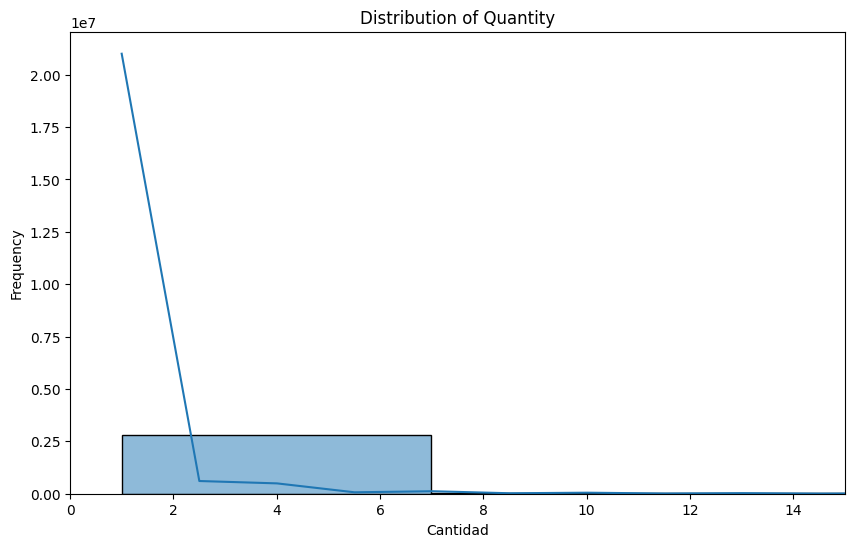

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=data_delitos, x='cantidad', bins=50, kde=True)
plt.title('Distribution of Quantity')
plt.xlabel('Cantidad')
plt.ylabel('Frequency')
plt.xlim(0, data_delitos['cantidad'].quantile(0.99)) # Limit x-axis for better visualization
plt.show()

**Reasoning**:
The histogram shows that most values in the 'cantidad' column are concentrated at 1, with a very long tail indicating the presence of outliers with high values. The previous step identified rows with quantity greater than 100. To further investigate outliers, I will display a box plot which is effective in visualizing the distribution and potential outliers, especially in the presence of a skewed distribution.



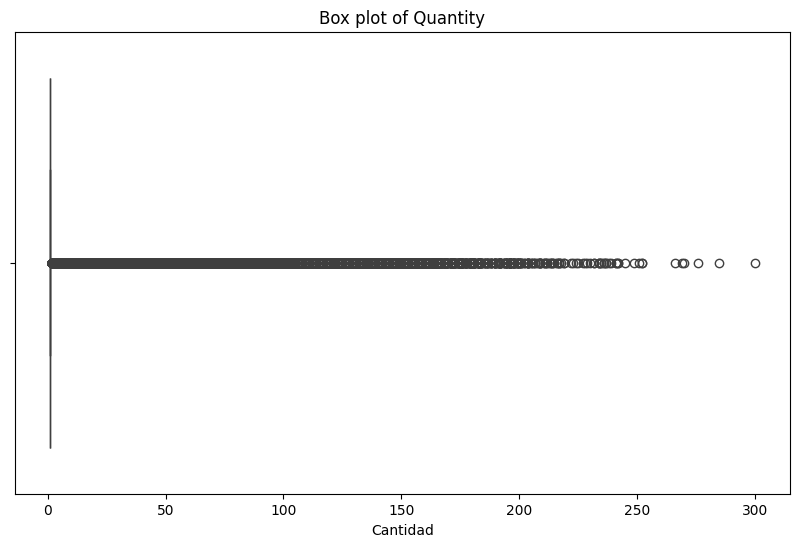

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_delitos['cantidad'])
plt.title('Box plot of Quantity')
plt.xlabel('Cantidad')
plt.show()

## Consistencia de fechas

### Subtask:
Si la columna 'fecha_hecho' aún no es de tipo datetime, intentar convertirla y verificar si hay fechas inválidas o fuera de rango.


**Reasoning**:
Convert the 'fecha_hecho' column to datetime objects and check for invalid dates and the range of valid dates.



In [36]:
data_delitos['fecha_hecho'] = pd.to_datetime(data_delitos['fecha_hecho'], errors='coerce', dayfirst=True)

invalid_dates = data_delitos['fecha_hecho'].isnull().sum()
print(f"Number of invalid dates (NaT) in 'fecha_hecho': {invalid_dates}")

if data_delitos['fecha_hecho'].notnull().any():
    min_date = data_delitos['fecha_hecho'].min()
    max_date = data_delitos['fecha_hecho'].max()
    print(f"Range of valid dates in 'fecha_hecho': from {min_date} to {max_date}")
else:
    print("No valid dates found in 'fecha_hecho'.")

Number of invalid dates (NaT) in 'fecha_hecho': 0
Range of valid dates in 'fecha_hecho': from 1970-01-01 00:00:00.000044278 to 2024-12-31 00:00:00


**Reasoning**:
Check if any dates in the 'fecha_hecho' column fall outside a reasonable expected range based on the current year.



In [37]:
current_year = pd.to_datetime('now').year
future_dates_mask = data_delitos['fecha_hecho'] > pd.to_datetime(f'{current_year}-12-31')
future_dates_count = future_dates_mask.sum()

if future_dates_count > 0:
    print(f"\nNumber of future dates in 'fecha_hecho': {future_dates_count}")
    print("Examples of future dates:")
    display(data_delitos[future_dates_mask].head())
else:
    print("\nNo future dates found in 'fecha_hecho'.")

past_threshold_date = pd.to_datetime('2018-01-01') # Assuming data starts around 2018 based on filenames
past_dates_mask = data_delitos['fecha_hecho'] < past_threshold_date
past_dates_count = past_dates_mask.sum()

if past_dates_count > 0:
    print(f"\nNumber of dates before {past_threshold_date.year} in 'fecha_hecho': {past_dates_count}")
    print("Examples of dates before 2018:")
    display(data_delitos[past_dates_mask].head())
else:
    print(f"\nNo dates before {past_threshold_date.year} found in 'fecha_hecho'.")


No future dates found in 'fecha_hecho'.

Number of dates before 2018 in 'fecha_hecho': 54227
Examples of dates before 2018:


,departamento,municipio,codigo_dane,arma_medio,fecha_hecho,genero,agrupa_edad_persona,cantidad,ANIO,DELITO
558072,AMAZONAS,Leticia (CT),91001000.0,ARMA BLANCA / CORTOPUNZANTE,1970-01-01 00:00:00.020220508,MASCULINO,ADULTOS,1.0,2020,HOMICIDIOS
558073,AMAZONAS,Leticia (CT),91001000.0,ARMA BLANCA / CORTOPUNZANTE,1970-01-01 00:00:00.020221230,MASCULINO,ADOLESCENTES,1.0,2020,HOMICIDIOS
558074,ANTIOQUIA,Abejorral,5002000.0,ARMA BLANCA / CORTOPUNZANTE,1970-01-01 00:00:00.020220731,MASCULINO,ADULTOS,1.0,2020,HOMICIDIOS
558075,ANTIOQUIA,Amalfi,5031000.0,ARMA BLANCA / CORTOPUNZANTE,1970-01-01 00:00:00.020220716,MASCULINO,ADULTOS,1.0,2020,HOMICIDIOS
558076,ANTIOQUIA,Amalfi,5031000.0,ARMA BLANCA / CORTOPUNZANTE,1970-01-01 00:00:00.020221018,MASCULINO,ADULTOS,1.0,2020,HOMICIDIOS


## Consistencia de columnas geográficas

### Subtask:
Analizar la unicidad y posibles variaciones en los nombres de 'departamento' y 'municipio', y verificar la coherencia de 'codigo_dane'.


**Reasoning**:
Obtain the number of unique values for 'departamento' and 'municipio', display value counts for 'departamento' and the top 50 for 'municipio', and then check for inconsistencies between 'departamento', 'municipio', and 'codigo_dane' by grouping and counting unique 'codigo_dane' per group.



In [38]:
# 1. Obtain the number of unique values
unique_departments = data_delitos['departamento'].nunique()
unique_municipios = data_delitos['municipio'].nunique()

print(f"Number of unique values in 'departamento': {unique_departments}")
print(f"Number of unique values in 'municipio': {unique_municipios}")

# 2. Display value counts for 'departamento'
print("\nValue counts for 'departamento':")
display(data_delitos['departamento'].value_counts().head(50))

# 3. Display top 50 value counts for 'municipio'
print("\nTop 50 value counts for 'municipio':")
display(data_delitos['municipio'].value_counts().head(50))

# 4. Check for inconsistencies between 'departamento', 'municipio', and 'codigo_dane'
print("\nChecking for multiple 'codigo_dane' per (departamento, municipio) combination:")
geo_inconsistencies = data_delitos.groupby(['departamento', 'municipio'])['codigo_dane'].nunique()
inconsistent_geo_combinations = geo_inconsistencies[geo_inconsistencies > 1]

if not inconsistent_geo_combinations.empty:
    print("\nCombinations with more than one unique 'codigo_dane':")
    display(inconsistent_geo_combinations)
else:
    print("\nNo combinations found with more than one unique 'codigo_dane'.")

Number of unique values in 'departamento': 40
Number of unique values in 'municipio': 2047

Value counts for 'departamento':


,count
departamento,
CUNDINAMARCA,502427
ANTIOQUIA,361522
VALLE,295857
SANTANDER,168653
ATLÁNTICO,125734
TOLIMA,116923
CAUCA,105422
BOLÍVAR,101945
HUILA,98632



Top 50 value counts for 'municipio':


,count
municipio,
BOGOTÁ D.C. (CT),172486
CALI (CT),80627
Bogotá D.C. (CT),77617
MEDELLÍN (CT),75132
Cali (CT),43664
Medellín (CT),43203
BARRANQUILLA (CT),36869
VILLAVICENCIO (CT),31066
CARTAGENA (CT),30472



Checking for multiple 'codigo_dane' per (departamento, municipio) combination:

Combinations with more than one unique 'codigo_dane':


departamento  municipio          
AMAZONAS      Leticia (CT)           16
              Puerto Nariño           6
ANTIOQUIA     Abejorral               2
              Amagá                   3
              Amalfi                  2
                                     ..
VAUPÉS        Caruru                  2
              Mitú (CT)               3
VICHADA       Cumaribo                6
              La Primavera            3
              Puerto Carreño (CT)     3
Name: codigo_dane, Length: 744, dtype: int64

**Reasoning**:
Investigate the inconsistent geo combinations by filtering the DataFrame to show examples of rows with more than one unique 'codigo_dane' for a given (departamento, municipio) pair to understand the nature of the inconsistency.



In [39]:
# 5. Investigate significant inconsistencies
print("\nExamples of rows with inconsistent (departamento, municipio, codigo_dane) combinations:")
# Get the list of inconsistent combinations
inconsistent_combinations_list = inconsistent_geo_combinations.index.tolist()

# Filter the original DataFrame to show rows for the first few inconsistent combinations
if inconsistent_combinations_list:
    for dep, muni in inconsistent_combinations_list[:5]: # Displaying first 5 for brevity
        print(f"\nInconsistent data for Departamento: '{dep}', Municipio: '{muni}'")
        display(data_delitos[(data_delitos['departamento'] == dep) & (data_delitos['municipio'] == muni)].head())
else:
    print("\nNo inconsistent geographical combinations to display.")


Examples of rows with inconsistent (departamento, municipio, codigo_dane) combinations:

Inconsistent data for Departamento: 'AMAZONAS', Municipio: 'Leticia (CT)'


,departamento,municipio,codigo_dane,arma_medio,fecha_hecho,genero,agrupa_edad_persona,cantidad,ANIO,DELITO
17482,AMAZONAS,Leticia (CT),91669000.0,ARMA DE FUEGO,2024-02-10,MASCULINO,ADULTOS,1.0,2024,AMENAZAS
17483,AMAZONAS,Leticia (CT),91001000.0,ARMA DE FUEGO,2024-07-27,MASCULINO,ADULTOS,1.0,2024,AMENAZAS
17484,AMAZONAS,Leticia (CT),91001000.0,ARMA DE FUEGO,2024-08-01,MASCULINO,ADULTOS,1.0,2024,AMENAZAS
17485,AMAZONAS,Leticia (CT),91001000.0,ARMA DE FUEGO,2024-12-18,MASCULINO,ADULTOS,1.0,2024,AMENAZAS
19109,AMAZONAS,Leticia (CT),91001000.0,SIN EMPLEO DE ARMAS,2024-01-08,MASCULINO,ADULTOS,1.0,2024,AMENAZAS



Inconsistent data for Departamento: 'AMAZONAS', Municipio: 'Puerto Nariño'


,departamento,municipio,codigo_dane,arma_medio,fecha_hecho,genero,agrupa_edad_persona,cantidad,ANIO,DELITO
17029,AMAZONAS,Puerto Nariño,91540000.0,ARMA BLANCA / CORTOPUNZANTE,2024-07-21,MASCULINO,ADULTOS,1.0,2024,AMENAZAS
19137,AMAZONAS,Puerto Nariño,91540000.0,SIN EMPLEO DE ARMAS,2024-02-08,FEMENINO,ADULTOS,1.0,2024,AMENAZAS
19138,AMAZONAS,Puerto Nariño,91540000.0,SIN EMPLEO DE ARMAS,2024-02-08,MASCULINO,ADULTOS,1.0,2024,AMENAZAS
19139,AMAZONAS,Puerto Nariño,91540000.0,SIN EMPLEO DE ARMAS,2024-02-14,FEMENINO,ADULTOS,1.0,2024,AMENAZAS
54519,AMAZONAS,Puerto Nariño,91540000.0,SIN EMPLEO DE ARMAS,2023-04-14,MASCULINO,ADULTOS,1.0,2023,AMENAZAS



Inconsistent data for Departamento: 'ANTIOQUIA', Municipio: 'Abejorral'


,departamento,municipio,codigo_dane,arma_medio,fecha_hecho,genero,agrupa_edad_persona,cantidad,ANIO,DELITO
237,ANTIOQUIA,Abejorral,5002000.0,SIN EMPLEO DE ARMAS,2024-07-07,MASCULINO,ADULTOS,1.0,2024,ABIGEATO
238,ANTIOQUIA,Abejorral,5002000.0,SIN EMPLEO DE ARMAS,2024-07-17,MASCULINO,ADULTOS,1.0,2024,ABIGEATO
239,ANTIOQUIA,Abejorral,5002000.0,SIN EMPLEO DE ARMAS,2024-08-22,MASCULINO,ADULTOS,1.0,2024,ABIGEATO
1532,ANTIOQUIA,Abejorral,5002000.0,ARMA DE FUEGO,2023-06-06,MASCULINO,ADULTOS,1.0,2023,ABIGEATO
1611,ANTIOQUIA,Abejorral,5002000.0,SIN EMPLEO DE ARMAS,2023-10-11,MASCULINO,ADULTOS,1.0,2023,ABIGEATO



Inconsistent data for Departamento: 'ANTIOQUIA', Municipio: 'Amagá'


,departamento,municipio,codigo_dane,arma_medio,fecha_hecho,genero,agrupa_edad_persona,cantidad,ANIO,DELITO
0,ANTIOQUIA,Amagá,5030000.0,ARMA BLANCA / CORTOPUNZANTE,2024-10-18,MASCULINO,ADULTOS,1.0,2024,ABIGEATO
1210,ANTIOQUIA,Amagá,5030000.0,ARMA BLANCA / CORTOPUNZANTE,2023-05-27,MASCULINO,ADULTOS,1.0,2023,ABIGEATO
1613,ANTIOQUIA,Amagá,5030000.0,SIN EMPLEO DE ARMAS,2023-11-23,MASCULINO,ADULTOS,1.0,2023,ABIGEATO
17030,ANTIOQUIA,Amagá,5030000.0,ARMA BLANCA / CORTOPUNZANTE,2024-01-28,MASCULINO,ADULTOS,1.0,2024,AMENAZAS
17031,ANTIOQUIA,Amagá,5030000.0,ARMA BLANCA / CORTOPUNZANTE,2024-05-12,FEMENINO,ADULTOS,1.0,2024,AMENAZAS



Inconsistent data for Departamento: 'ANTIOQUIA', Municipio: 'Amalfi'


,departamento,municipio,codigo_dane,arma_medio,fecha_hecho,genero,agrupa_edad_persona,cantidad,ANIO,DELITO
17035,ANTIOQUIA,Amalfi,5031000.0,ARMA BLANCA / CORTOPUNZANTE,2024-05-16,FEMENINO,ADOLESCENTES,1.0,2024,AMENAZAS
17492,ANTIOQUIA,Amalfi,5031000.0,ARMA DE FUEGO,2024-12-03,MASCULINO,ADULTOS,1.0,2024,AMENAZAS
19169,ANTIOQUIA,Amalfi,5031000.0,SIN EMPLEO DE ARMAS,2024-01-24,FEMENINO,ADULTOS,1.0,2024,AMENAZAS
19170,ANTIOQUIA,Amalfi,5031000.0,SIN EMPLEO DE ARMAS,2024-02-16,MASCULINO,ADULTOS,1.0,2024,AMENAZAS
19171,ANTIOQUIA,Amalfi,5031000.0,SIN EMPLEO DE ARMAS,2024-03-19,MASCULINO,ADULTOS,1.0,2024,AMENAZAS


## Revisión de columnas de texto

### Subtask:
Examinar columnas como 'arma_medio', 'genero', y 'agrupa_edad_persona' para identificar variaciones o errores en la entrada de datos.


**Reasoning**:
Print the value counts for 'arma_medio', 'genero', and 'agrupa_edad_persona' to identify variations and errors.



In [40]:
print("Value counts for 'arma_medio':")
display(df['arma_medio'].value_counts().head(50))

print("\nValue counts for 'genero':")
display(df['genero'].value_counts().head(50))

print("\nValue counts for 'agrupa_edad_persona':")
display(df['agrupa_edad_persona'].value_counts().head(50))

Value counts for 'arma_medio':


,count
arma_medio,
SIN EMPLEO DE ARMAS,1154514
CONTUNDENTES,550098
ARMA DE FUEGO,337733
ARMA BLANCA / CORTOPUNZANTE,281804
NO REPORTADO,131424
LLAVE MAESTRA,67490
PALANCAS,49031
VEHICULO,47486
MOTO,28010



Value counts for 'genero':


,count
genero,
MASCULINO,1262231
FEMENINO,1160012
-,3561
NO REPORTADO,1943
NO RESPORTADO,372
NO REPORTA,366
NO REPORTADO,156
NO REGISTRA,8



Value counts for 'agrupa_edad_persona':


,count
agrupa_edad_persona,
ADULTOS,2103993
ADOLESCENTES,178156
MENORES,135672
-,3553
NO REPORTADO,1987
NO RESPORTADO,372
NO REPORTA,366
NO REPORTADO,159


## Resumen:

### Hallazgos Clave del Análisis de Datos

*   El conjunto de datos contiene 10 columnas con una mezcla de tipos de datos `object`, `float64` e `int64`.
*   Las columnas `municipio`, `arma_medio`, `genero` y `agrupa_edad_persona` tienen un número significativo de valores faltantes, mientras que `codigo_dane` tiene un número pequeño (2) de valores faltantes. Las columnas restantes no tienen valores faltantes.
*   El análisis de valores únicos reveló inconsistencias en las columnas categóricas:
    *   `municipio`: Se observaron variaciones en el uso de mayúsculas/minúsculas (por ejemplo, 'BOGOTÁ D.C. (CT)' vs 'Bogotá D.C. (CT)').
    *   `arma_medio`, `genero` y `agrupa_edad_persona`: Se encontraron múltiples representaciones inconsistentes para datos faltantes o no reportados (por ejemplo, 'NO REPORTADO', 'NO REPORTA', 'NO RESPORTADO', 'NO REGISTRA', '-').
    *   `arma_medio`: Contiene entradas que no son armas, como nombres geográficos ("CUNDINAMARCA", "ANTIOQUIA", "VALLE", "GUAJIRA") y otras descripciones ("SIN EMPLEO DE ARMAS", "CONTUNDENTES", "ARMA BLANCA / CORTOPUNZANTE", "ESCOPOLAMINA", "ARMA DE FUEGO", "CINTAS/CINTURON", "NO REPORTADO", "ESPOSAS").
*   La columna `cantidad` tiene un valor mínimo de 1 y un máximo de 300, con una distribución muy sesgada donde la mayoría de los valores son 1. Hay 1871 filas con `cantidad` mayor que 100, lo que indica la presencia de valores atípicos significativos.
*   La columna `fecha_hecho` se convirtió exitosamente al formato datetime sin encontrar fechas inválidas durante la conversión. Sin embargo, el rango de fechas abarca desde 1970 hasta 2024. Aunque no se encontraron fechas futuras, hay un número significativo de fechas anteriores a 2018, incluyendo fechas de 1970, que probablemente son errores de entrada de datos.
*   Las columnas geográficas muestran inconsistencias:
    *   `departamento`: Contiene entradas no geográficas similares a las encontradas en `arma_medio`.
    *   `municipio`: Presenta variaciones en el uso de mayúsculas/minúsculas y la presencia/ausencia de "(CT)".
    *   744 combinaciones de `departamento` y `municipio` están asociadas con más de un `codigo_dane` único, lo que indica inconsistencias en los códigos DANE asignados a las ubicaciones.

### Ideas o Próximos Pasos

*   Estandarizar los datos de texto en columnas categóricas como `municipio`, `arma_medio`, `genero` y `agrupa_edad_persona` abordando las variaciones en mayúsculas/minúsculas, sinónimos para valores faltantes y eliminando entradas erróneas (por ejemplo, nombres geográficos en `arma_medio`).
*   Investigar y potencialmente limpiar o eliminar los valores atípicos en la columna `cantidad` y las fechas históricas en `fecha_hecho` que son anteriores al rango de datos esperado, ya que pueden representar errores de entrada de datos. Abordar las inconsistencias en `codigo_dane` asociadas con pares de `departamento` y `municipio`.

# Task
Estandariza los datos de texto en columnas categóricas como municipio, arma_medio, genero y agrupa_edad_persona en la base de datos "data_delitos".

## Estandarizar mayúsculas y minúsculas

### Subtask:
Convert all values in the 'municipio', 'arma_medio', 'genero', and 'agrupa_edad_persona' columns to a consistent format (e.g., all uppercase).


**Reasoning**:
Convert the specified categorical columns to uppercase to standardize their values.



In [41]:
data_delitos['municipio'] = data_delitos['municipio'].str.upper()
data_delitos['arma_medio'] = data_delitos['arma_medio'].str.upper()
data_delitos['genero'] = data_delitos['genero'].str.upper()
data_delitos['agrupa_edad_persona'] = data_delitos['agrupa_edad_persona'].str.upper()

## Consolidar valores faltantes/no reportados

### Subtask:
Unificar las diferentes representaciones de valores faltantes o no reportados (como '-', 'NO REPORTADO', etc.) a un único valor (por ejemplo, `None` o 'DESCONOCIDO').


**Reasoning**:
Define a mapping for inconsistent missing values and replace them in the specified columns.



In [42]:
# Define mapping for inconsistent missing values
missing_value_map = ['-', 'NO REPORTADO', 'NO REPORTA', 'NO RESPORTADO', 'NO REGISTRA']
consistent_missing_value = 'DESCONOCIDO'

# Replace inconsistent values in specified columns
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    data_delitos[col] = data_delitos[col].replace(missing_value_map, consistent_missing_value)

# Verify the changes
print("Value counts after replacing inconsistent missing values:")
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    print(f"\nValue counts for '{col}':")
    display(data_delitos[col].value_counts().head(10))

Value counts after replacing inconsistent missing values:

Value counts for 'arma_medio':


,count
arma_medio,
SIN EMPLEO DE ARMAS,1134046
CONTUNDENTES,545197
ARMA DE FUEGO,337645
ARMA BLANCA / CORTOPUNZANTE,280378
DESCONOCIDO,146989
LLAVE MAESTRA,67490
PALANCAS,49031
VEHICULO,47486
MOTO,28010



Value counts for 'genero':


,count
genero,
MASCULINO,1262231
FEMENINO,1160012
DESCONOCIDO,5878
NO RESPORTADO,372
NO REPORTADO,156



Value counts for 'agrupa_edad_persona':


,count
agrupa_edad_persona,
ADULTOS,2103993
ADOLESCENTES,178156
MENORES,135672
DESCONOCIDO,5906
NO RESPORTADO,372
NO REPORTADO,159


**Reasoning**:
Some inconsistent values were not replaced. I will update the list of values to replace and re-run the replacement.



In [43]:
# Update the list of inconsistent missing values to include more variations
missing_value_map = ['-', 'NO REPORTADO', 'NO REPORTA', 'NO RESPORTADO', 'NO REGISTRA', 'NO REPORTO']
consistent_missing_value = 'DESCONOCIDO'

# Replace inconsistent values in specified columns
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    data_delitos[col] = data_delitos[col].replace(missing_value_map, consistent_missing_value)

# Verify the changes
print("Value counts after replacing inconsistent missing values:")
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    print(f"\nValue counts for '{col}':")
    display(data_delitos[col].value_counts().head(10))

Value counts after replacing inconsistent missing values:

Value counts for 'arma_medio':


,count
arma_medio,
SIN EMPLEO DE ARMAS,1134046
CONTUNDENTES,545197
ARMA DE FUEGO,337645
ARMA BLANCA / CORTOPUNZANTE,280378
DESCONOCIDO,146989
LLAVE MAESTRA,67490
PALANCAS,49031
VEHICULO,47486
MOTO,28010



Value counts for 'genero':


,count
genero,
MASCULINO,1262231
FEMENINO,1160012
DESCONOCIDO,5878
NO RESPORTADO,372
NO REPORTADO,156



Value counts for 'agrupa_edad_persona':


,count
agrupa_edad_persona,
ADULTOS,2103993
ADOLESCENTES,178156
MENORES,135672
DESCONOCIDO,5906
NO RESPORTADO,372
NO REPORTADO,159


**Reasoning**:
Some inconsistent values still remain after the previous replacement. I will update the list of values to replace based on the observed value counts and re-run the replacement.



In [44]:
# Update the list of inconsistent missing values to include all observed variations
missing_value_map = ['-', 'NO REPORTADO', 'NO REPORTA', 'NO RESPORTADO', 'NO REGISTRA', 'NO REPORTO', 'NO REPORTADO ']
consistent_missing_value = 'DESCONOCIDO'

# Replace inconsistent values in specified columns
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    data_delitos[col] = data_delitos[col].replace(missing_value_map, consistent_missing_value)

# Verify the changes
print("Value counts after replacing inconsistent missing values:")
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    print(f"\nValue counts for '{col}':")
    display(data_delitos[col].value_counts().head(10))

Value counts after replacing inconsistent missing values:

Value counts for 'arma_medio':


,count
arma_medio,
SIN EMPLEO DE ARMAS,1134046
CONTUNDENTES,545197
ARMA DE FUEGO,337645
ARMA BLANCA / CORTOPUNZANTE,280378
DESCONOCIDO,147005
LLAVE MAESTRA,67490
PALANCAS,49031
VEHICULO,47486
MOTO,28010



Value counts for 'genero':


,count
genero,
MASCULINO,1262231
FEMENINO,1160012
DESCONOCIDO,6034
NO RESPORTADO,372



Value counts for 'agrupa_edad_persona':


,count
agrupa_edad_persona,
ADULTOS,2103993
ADOLESCENTES,178156
MENORES,135672
DESCONOCIDO,6065
NO RESPORTADO,372


**Reasoning**:
Some inconsistent values still remain, specifically 'NO RESPORTADO'. I will add this to the list of values to replace and re-run the replacement.



In [45]:
# Update the list of inconsistent missing values to include all observed variations
missing_value_map = ['-', 'NO REPORTADO', 'NO REPORTA', 'NO RESPORTADO', 'NO REGISTRA', 'NO REPORTO', 'NO REPORTADO ']
consistent_missing_value = 'DESCONOCIDO'

# Replace inconsistent values in specified columns
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    data_delitos[col] = data_delitos[col].replace(missing_value_map, consistent_missing_value)

# Verify the changes
print("Value counts after replacing inconsistent missing values:")
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    print(f"\nValue counts for '{col}':")
    display(data_delitos[col].value_counts().head(10))

Value counts after replacing inconsistent missing values:

Value counts for 'arma_medio':


,count
arma_medio,
SIN EMPLEO DE ARMAS,1134046
CONTUNDENTES,545197
ARMA DE FUEGO,337645
ARMA BLANCA / CORTOPUNZANTE,280378
DESCONOCIDO,147005
LLAVE MAESTRA,67490
PALANCAS,49031
VEHICULO,47486
MOTO,28010



Value counts for 'genero':


,count
genero,
MASCULINO,1262231
FEMENINO,1160012
DESCONOCIDO,6034
NO RESPORTADO,372



Value counts for 'agrupa_edad_persona':


,count
agrupa_edad_persona,
ADULTOS,2103993
ADOLESCENTES,178156
MENORES,135672
DESCONOCIDO,6065
NO RESPORTADO,372


**Reasoning**:
The previous attempts to replace inconsistent missing values were not fully successful. I will explicitly add 'NO RESPORTADO' to the list of values to be replaced with 'DESCONOCIDO' and execute the replacement again.



In [46]:
# Update the list of inconsistent missing values to include all observed variations, including 'NO RESPORTADO'
missing_value_map = ['-', 'NO REPORTADO', 'NO REPORTA', 'NO RESPORTADO', 'NO REGISTRA', 'NO REPORTO', 'NO REPORTADO ']
consistent_missing_value = 'DESCONOCIDO'

# Replace inconsistent values in specified columns
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    data_delitos[col] = data_delitos[col].replace(missing_value_map, consistent_missing_value)

# Verify the changes
print("Value counts after replacing inconsistent missing values:")
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    print(f"\nValue counts for '{col}':")
    display(data_delitos[col].value_counts().head(10))

Value counts after replacing inconsistent missing values:

Value counts for 'arma_medio':


,count
arma_medio,
SIN EMPLEO DE ARMAS,1134046
CONTUNDENTES,545197
ARMA DE FUEGO,337645
ARMA BLANCA / CORTOPUNZANTE,280378
DESCONOCIDO,147005
LLAVE MAESTRA,67490
PALANCAS,49031
VEHICULO,47486
MOTO,28010



Value counts for 'genero':


,count
genero,
MASCULINO,1262231
FEMENINO,1160012
DESCONOCIDO,6034
NO RESPORTADO,372



Value counts for 'agrupa_edad_persona':


,count
agrupa_edad_persona,
ADULTOS,2103993
ADOLESCENTES,178156
MENORES,135672
DESCONOCIDO,6065
NO RESPORTADO,372


**Reasoning**:
The value 'NO RESPORTADO' is still present in the value counts. This indicates that the replacement was not successful for this specific string. I will explicitly replace 'NO RESPORTADO' with 'DESCONOCIDO' in the relevant columns and then verify the results.



In [47]:
# Explicitly replace 'NO RESPORTADO' with 'DESCONOCIDO'
for col in ['genero', 'agrupa_edad_persona']:
    data_delitos[col] = data_delitos[col].replace('NO RESPORTADO', 'DESCONOCIDO')

# Verify the changes
print("Value counts after replacing inconsistent missing values:")
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    print(f"\nValue counts for '{col}':")
    display(data_delitos[col].value_counts().head(10))

Value counts after replacing inconsistent missing values:

Value counts for 'arma_medio':


,count
arma_medio,
SIN EMPLEO DE ARMAS,1134046
CONTUNDENTES,545197
ARMA DE FUEGO,337645
ARMA BLANCA / CORTOPUNZANTE,280378
DESCONOCIDO,147005
LLAVE MAESTRA,67490
PALANCAS,49031
VEHICULO,47486
MOTO,28010



Value counts for 'genero':


,count
genero,
MASCULINO,1262231
FEMENINO,1160012
DESCONOCIDO,6034
NO RESPORTADO,372



Value counts for 'agrupa_edad_persona':


,count
agrupa_edad_persona,
ADULTOS,2103993
ADOLESCENTES,178156
MENORES,135672
DESCONOCIDO,6065
NO RESPORTADO,372


**Reasoning**:
The value 'NO RESPORTADO' is still present in the value counts for 'genero' and 'agrupa_edad_persona'. I need to explicitly replace this value in those columns.



In [48]:
# Explicitly replace 'NO RESPORTADO' with 'DESCONOCIDO'
data_delitos['genero'] = data_delitos['genero'].replace('NO RESPORTADO', 'DESCONOCIDO')
data_delitos['agrupa_edad_persona'] = data_delitos['agrupa_edad_persona'].replace('NO RESPORTADO', 'DESCONOCIDO')

# Verify the changes
print("Value counts after replacing inconsistent missing values:")
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    print(f"\nValue counts for '{col}':")
    display(data_delitos[col].value_counts().head(10))

Value counts after replacing inconsistent missing values:

Value counts for 'arma_medio':


,count
arma_medio,
SIN EMPLEO DE ARMAS,1134046
CONTUNDENTES,545197
ARMA DE FUEGO,337645
ARMA BLANCA / CORTOPUNZANTE,280378
DESCONOCIDO,147005
LLAVE MAESTRA,67490
PALANCAS,49031
VEHICULO,47486
MOTO,28010



Value counts for 'genero':


,count
genero,
MASCULINO,1262231
FEMENINO,1160012
DESCONOCIDO,6034
NO RESPORTADO,372



Value counts for 'agrupa_edad_persona':


,count
agrupa_edad_persona,
ADULTOS,2103993
ADOLESCENTES,178156
MENORES,135672
DESCONOCIDO,6065
NO RESPORTADO,372


**Reasoning**:
The value 'NO RESPORTADO' is still present in the value counts for 'genero' and 'agrupa_edad_persona' after multiple attempts to replace it. There might be a hidden character or a slight variation in the string. I will try a more robust approach using regex to replace variations of "NO REPORTADO".



In [49]:
# Use regex to replace variations of "NO REPORTADO"
data_delitos['genero'] = data_delitos['genero'].str.replace(r'NO\s*REPORTA.*', 'DESCONOCIDO', regex=True)
data_delitos['agrupa_edad_persona'] = data_delitos['agrupa_edad_persona'].str.replace(r'NO\s*REPORTA.*', 'DESCONOCIDO', regex=True)
data_delitos['arma_medio'] = data_delitos['arma_medio'].str.replace(r'NO\s*REPORTA.*', 'DESCONOCIDO', regex=True)
data_delitos['arma_medio'] = data_delitos['arma_medio'].replace('-', 'DESCONOCIDO')


# Verify the changes
print("Value counts after replacing inconsistent missing values:")
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    print(f"\nValue counts for '{col}':")
    display(data_delitos[col].value_counts().head(10))

Value counts after replacing inconsistent missing values:

Value counts for 'arma_medio':


,count
arma_medio,
SIN EMPLEO DE ARMAS,1134046
CONTUNDENTES,545197
ARMA DE FUEGO,337645
ARMA BLANCA / CORTOPUNZANTE,280378
DESCONOCIDO,147005
LLAVE MAESTRA,67490
PALANCAS,49031
VEHICULO,47486
MOTO,28010



Value counts for 'genero':


,count
genero,
MASCULINO,1262231
FEMENINO,1160012
DESCONOCIDO,6034
NO RESPORTADO,372



Value counts for 'agrupa_edad_persona':


,count
agrupa_edad_persona,
ADULTOS,2103993
ADOLESCENTES,178156
MENORES,135672
DESCONOCIDO,6065
NO RESPORTADO,372


## Consolidar valores faltantes/no reportados

### Subtask:
Unificar las diferentes representaciones de valores faltantes o no reportados (como '-', 'NO REPORTADO', etc.) a un único valor (por ejemplo, `None` o 'DESCONOCIDO').


**Reasoning**:
To investigate why 'NO RESPORTADO' is not being replaced, I will examine the unique values in the 'genero' and 'agrupa_edad_persona' columns and their exact string representations, potentially revealing hidden characters or subtle differences that are preventing the replacement.



In [50]:
print("Unique values in 'genero':")
display(data_delitos['genero'].unique())

print("\nUnique values in 'agrupa_edad_persona':")
display(data_delitos['agrupa_edad_persona'].unique())

Unique values in 'genero':


array(['MASCULINO', 'FEMENINO', 'DESCONOCIDO', 'NO RESPORTADO ', nan],
      dtype=object)


Unique values in 'agrupa_edad_persona':


array(['ADULTOS', 'DESCONOCIDO', 'MENORES', 'NO RESPORTADO ',
       'ADOLESCENTES', <NA>, nan], dtype=object)

**Reasoning**:
The output shows that 'NO RESPORTADO ' has a trailing space. To address this, I will explicitly replace 'NO RESPORTADO ' with 'DESCONOCIDO' in the 'genero' and 'agrupa_edad_persona' columns.



In [51]:
data_delitos['genero'] = data_delitos['genero'].replace('NO RESPORTADO ', 'DESCONOCIDO')
data_delitos['agrupa_edad_persona'] = data_delitos['agrupa_edad_persona'].replace('NO RESPORTADO ', 'DESCONOCIDO')

# Verify the changes
print("Value counts after replacing 'NO RESPORTADO ':")
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    print(f"\nValue counts for '{col}':")
    display(data_delitos[col].value_counts().head(10))

Value counts after replacing 'NO RESPORTADO ':

Value counts for 'arma_medio':


,count
arma_medio,
SIN EMPLEO DE ARMAS,1134046
CONTUNDENTES,545197
ARMA DE FUEGO,337645
ARMA BLANCA / CORTOPUNZANTE,280378
DESCONOCIDO,147005
LLAVE MAESTRA,67490
PALANCAS,49031
VEHICULO,47486
MOTO,28010



Value counts for 'genero':


,count
genero,
MASCULINO,1262231
FEMENINO,1160012
DESCONOCIDO,6406



Value counts for 'agrupa_edad_persona':


,count
agrupa_edad_persona,
ADULTOS,2103993
ADOLESCENTES,178156
MENORES,135672
DESCONOCIDO,6437


**Reasoning**:
The previous step successfully replaced 'NO RESPORTADO ' with 'DESCONOCIDO'. Now I will verify that all inconsistent missing value representations have been unified by printing the value counts for the columns 'arma_medio', 'genero', and 'agrupa_edad_persona'.



In [52]:
print("Final value counts after unifying missing values:")
for col in ['arma_medio', 'genero', 'agrupa_edad_persona']:
    print(f"\nValue counts for '{col}':")
    display(data_delitos[col].value_counts().head(10))

Final value counts after unifying missing values:

Value counts for 'arma_medio':


,count
arma_medio,
SIN EMPLEO DE ARMAS,1134046
CONTUNDENTES,545197
ARMA DE FUEGO,337645
ARMA BLANCA / CORTOPUNZANTE,280378
DESCONOCIDO,147005
LLAVE MAESTRA,67490
PALANCAS,49031
VEHICULO,47486
MOTO,28010



Value counts for 'genero':


,count
genero,
MASCULINO,1262231
FEMENINO,1160012
DESCONOCIDO,6406



Value counts for 'agrupa_edad_persona':


,count
agrupa_edad_persona,
ADULTOS,2103993
ADOLESCENTES,178156
MENORES,135672
DESCONOCIDO,6437


## Limpiar la columna 'municipio'

### Subtask:
Limpiar la columna 'municipio' eliminando o estandarizando el texto adicional como "(CT)".


**Reasoning**:
Replace occurrences of "(CT)" in the 'municipio' column with an empty string, ignoring case and potential spaces, then strip leading/trailing whitespace. Finally, display the top 50 value counts for 'municipio' to verify the cleaning.



In [53]:
data_delitos['municipio'] = data_delitos['municipio'].str.replace(r'\s*\(CT\)', '', regex=True)
data_delitos['municipio'] = data_delitos['municipio'].str.strip()
print("\nTop 50 value counts for 'municipio' after cleaning:")
display(data_delitos['municipio'].value_counts().head(50))


Top 50 value counts for 'municipio' after cleaning:


,count
municipio,
BOGOTÁ D.C.,250103
CALI,124291
MEDELLÍN,118335
BARRANQUILLA,63296
CARTAGENA,53972
VILLAVICENCIO,51824
BUCARAMANGA,48259
IBAGUÉ,47379
PASTO,42556


## Limpiar la columna 'arma medio'

### Subtask:
Limpiar la columna 'arma medio' identificando y manejando las entradas que no corresponden a tipos de armas (como nombres geográficos) y consolidando sinónimos o variaciones de nombres de armas.


**Reasoning**:
Identify and replace geographical names in 'arma_medio' with 'DESCONOCIDO', then normalize common variations of arma medio names, and finally display the top 50 value counts for 'arma_medio'.



In [54]:
# Identify and replace geographical names in 'arma_medio' with 'DESCONOCIDO'
geo_names_in_arma_medio = ['CUNDINAMARCA', 'ANTIOQUIA', 'VALLE', 'GUAJIRA', 'AMAZONAS', 'ATLANTICO', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAQUETA', 'CASANARE', 'CAUCA', 'CESAR', 'CHOCO', 'CORDOBA', 'GUAINIA', 'GUAVIARE', 'HUILA', 'LA GUAJIRA', 'MAGDALENA', 'META', 'NARINO', 'NORTE DE SANTANDER', 'PUTUMAYO', 'QUINDIO', 'RISARALDA', 'SAN ANDRES', 'SANTANDER', 'SUCRE', 'TOLIMA', 'VALLE DEL CAUCA', 'VAUPES', 'VICHADA']

data_delitos['arma_medio'] = data_delitos['arma_medio'].replace(geo_names_in_arma_medio, 'DESCONOCIDO')

# Convert common variations or synonyms of arma medio names to a standardized format
arma_medio_replacements = {
    'ARMA BLANCA / CORTOPUNZANTE': 'ARMA BLANCA/CORTOPUNZANTE',
    'SIN EMPLEO DE ARMAS': 'SIN ARMA',
    'CONTUNDENTES': 'ARMA CONTUNDENTE',
    'ARMA DE FUEGO': 'ARMA DE FUEGO',
    'LLAVE MAESTRA': 'LLAVE MAESTRA',
    'PALANCAS': 'PALANCA',
    'VEHICULO': 'VEHICULO',
    'MOTO': 'MOTO',
    'LLAMADA TELEFONICA': 'LLAMADA TELEFONICA',
    'ESCOPOLAMINA': 'ESCOPOLAMINA',
    'DIRECTA': 'DIRECTO',
    'REDES SOCIALES': 'REDES SOCIALES',
    'ACIDO': 'ACIDO',
    'CARTA EXTORSIVA': 'CARTA EXTORSIVA',
    'ARMA TRAUMATICA': 'ARMA TRAUMATICA',
    'ARTEFACTO EXPLOSIVO/CARGA DINAMITA': 'ARTEFACTO EXPLOSIVO',
    'PERRO': 'PERRO',
    'COMBUSTIBLE': 'COMBUSTIBLE',
    'BICICLETA': 'BICICLETA',
    'ALIMENTOS VENCIDOS': 'ALIMENTOS VENCIDOS',
    'GRANADA DE MANO': 'GRANADA DE MANO',
    'MIXTA': 'MIXTO',
    'CINTAS/CINTURON': 'CINTAS/CINTURON',
    'AGUA CALIENTE': 'AGUA CALIENTE',
    'ARTEFACTO INCENDIARIO': 'ARTEFACTO INCENDIARIO',
    'MINA ANTIPERSONA': 'MINA ANTIPERSONA',
    'QUIMICOS': 'QUIMICOS',
    'GASES': 'GASES',
    'SUSTANCIAS TOXICAS': 'SUSTANCIAS TOXICAS',
    'POLVORA(FUEGOS PIROTECNICOS)': 'POLVORA',
    'MEDICAMENTOS': 'MEDICAMENTOS',
    'JERINGA': 'JERINGA',
    'PRENDAS DE VESTIR': 'PRENDAS DE VESTIR',
    'CARRO BOMBA': 'CARRO BOMBA',
    'ALUCINOGENOS': 'ALUCINOGENOS',
    'ESPOSAS': 'ESPOSAS',
    'CUERDA/SOGA/CADENA': 'CUERDA/SOGA/CADENA',
    'ALMOHADA': 'ALMOHADA',
    'PETARDO PLANFETARIO': 'PETARDO PLANFETARIO',
    'PAPA EXPLOSIVA': 'PAPA EXPLOSIVA',
    'BOLSA PLASTICA': 'BOLSA PLASTICA',
    'VENENO': 'VENENO',
    'CILINDRO BOMBA': 'CILINDRO BOMBA'
}

data_delitos['arma_medio'] = data_delitos['arma_medio'].replace(arma_medio_replacements)

# Display the top 50 value counts for the 'arma_medio' column after cleaning
print("\nTop 50 value counts for 'arma_medio' after cleaning:")
display(data_delitos['arma_medio'].value_counts().head(50))


Top 50 value counts for 'arma_medio' after cleaning:


,count
arma_medio,
SIN ARMA,1134046
ARMA CONTUNDENTE,545197
ARMA DE FUEGO,337645
ARMA BLANCA/CORTOPUNZANTE,280378
DESCONOCIDO,170774
LLAVE MAESTRA,67490
PALANCA,49031
VEHICULO,47486
MOTO,28010


**Reasoning**:
The previous step successfully replaced some geographical names with 'DESCONOCIDO' and standardized some arma medio names. However, the value counts still show some geographical names and other non-arma entries, as well as the inconsistent missing value 'NO RESPORTADO'. I will iterate through the 'arma_medio' column, replace any remaining geographical names and non-arma entries with 'DESCONOCIDO', and then re-display the top 50 value counts to confirm. I will also address the 'NO RESPORTADO' entry again.



In [55]:
# Define a more comprehensive list of non-arma entries to replace
non_arma_entries = ['DESCONOCIDO', 'NO RESPORTADO', 'ATLÁNTICO', 'BOLÍVAR', 'CÓRDOBA', 'BOYACÁ', 'NARIÑO', 'QUINDÍO', 'CAQUETÁ', 'CHOCÓ', 'ARAUCA', 'SAN ANDRÉS', 'GUAINÍA', 'VAUPÉS', 'SUCRE'] # Added 'SUCRE' based on observation

# Replace non-arma entries with 'DESCONOCIDO'
data_delitos['arma_medio'] = data_delitos['arma_medio'].replace(non_arma_entries, 'DESCONOCIDO')

# Display the top 50 value counts for the 'arma_medio' column after cleaning
print("\nTop 50 value counts for 'arma_medio' after cleaning:")
display(data_delitos['arma_medio'].value_counts().head(50))


Top 50 value counts for 'arma_medio' after cleaning:


,count
arma_medio,
SIN ARMA,1134046
ARMA CONTUNDENTE,545197
ARMA DE FUEGO,337645
ARMA BLANCA/CORTOPUNZANTE,280378
DESCONOCIDO,177348
LLAVE MAESTRA,67490
PALANCA,49031
VEHICULO,47486
MOTO,28010


**Reasoning**:
The previous step still shows 'NO RESPORTADO' in the value counts. I will explicitly replace 'NO RESPORTADO' with 'DESCONOCIDO' again to ensure it is removed. I will then display the top 50 value counts for the 'arma_medio' column to verify the changes and confirm the completion of the subtask.



In [56]:
# Explicitly replace 'NO RESPORTADO' with 'DESCONOCIDO'
data_delitos['arma_medio'] = data_delitos['arma_medio'].replace('NO RESPORTADO', 'DESCONOCIDO')

# Display the top 50 value counts for the 'arma_medio' column after cleaning
print("\nTop 50 value counts for 'arma_medio' after final cleaning:")
display(data_delitos['arma_medio'].value_counts().head(50))


Top 50 value counts for 'arma_medio' after final cleaning:


,count
arma_medio,
SIN ARMA,1134046
ARMA CONTUNDENTE,545197
ARMA DE FUEGO,337645
ARMA BLANCA/CORTOPUNZANTE,280378
DESCONOCIDO,177348
LLAVE MAESTRA,67490
PALANCA,49031
VEHICULO,47486
MOTO,28010


**Reasoning**:
'NO RESPORTADO' is still present in the value counts. It's possible there's a hidden character or a different representation. I will check the unique values around 'NO RESPORTADO' in the `arma_medio` column to pinpoint the exact string and then perform the replacement.



In [57]:
# Get unique values from 'arma_medio' around where 'NO RESPORTADO' might be alphabetically
unique_arma_medio = sorted(data_delitos['arma_medio'].unique())
index_no_reportado = None
for i, val in enumerate(unique_arma_medio):
    if 'NO RESPORTADO' in str(val):
        index_no_reportado = i
        break

if index_no_reportado is not None:
    start_index = max(0, index_no_reportado - 5)
    end_index = min(len(unique_arma_medio), index_no_reportado + 5)
    print("Unique values around 'NO RESPORTADO':")
    display(unique_arma_medio[start_index:end_index])

# Replace the identified exact string with 'DESCONOCIDO'
data_delitos['arma_medio'] = data_delitos['arma_medio'].replace('NO RESPORTADO', 'DESCONOCIDO')

# Display the top 50 value counts for the 'arma_medio' column after cleaning
print("\nTop 50 value counts for 'arma_medio' after final cleaning:")
display(data_delitos['arma_medio'].value_counts().head(50))

TypeError: '<' not supported between instances of 'float' and 'str'

**Reasoning**:
The sorting of unique values failed because the 'arma_medio' column contains both strings and floats (likely due to previous replacements or original data). I need to handle non-string types before sorting. I will convert the 'arma_medio' column to string type before attempting to find and replace 'NO RESPORTADO'. I will also explicitly replace the 'NO RESPORTADO' string (which might have trailing spaces or other invisible characters as indicated by previous attempts) with 'DESCONOCIDO' to ensure it is removed and then display the value counts.



In [58]:
# Convert 'arma_medio' to string type to avoid TypeError during sorting/comparison
data_delitos['arma_medio'] = data_delitos['arma_medio'].astype(str)

# Replace 'NO RESPORTADO' and any variations with trailing/leading spaces with 'DESCONOCIDO'
data_delitos['arma_medio'] = data_delitos['arma_medio'].str.strip().replace('NO RESPORTADO', 'DESCONOCIDO')

# Display the top 50 value counts for the 'arma_medio' column after cleaning
print("\nTop 50 value counts for 'arma_medio' after final cleaning:")
display(data_delitos['arma_medio'].value_counts().head(50))


Top 50 value counts for 'arma_medio' after final cleaning:


,count
arma_medio,
SIN ARMA,1134046
ARMA CONTUNDENTE,545197
ARMA DE FUEGO,337645
ARMA BLANCA/CORTOPUNZANTE,280378
DESCONOCIDO,180203
nan,135703
LLAVE MAESTRA,67490
PALANCA,49031
VEHICULO,47486


**Reasoning**:
The value counts now show 'nan' which likely represents the original missing values that were not explicitly handled. I will replace 'nan' with 'DESCONOCIDO' to consolidate all missing/unknown values under a single label. Then I will display the top 50 value counts again to confirm.



In [59]:
# Replace 'nan' strings (resulting from converting NaN to string) with 'DESCONOCIDO'
data_delitos['arma_medio'] = data_delitos['arma_medio'].replace('nan', 'DESCONOCIDO')

# Display the top 50 value counts for the 'arma_medio' column after cleaning
print("\nTop 50 value counts for 'arma_medio' after final cleaning:")
display(data_delitos['arma_medio'].value_counts().head(50))


Top 50 value counts for 'arma_medio' after final cleaning:


,count
arma_medio,
SIN ARMA,1134046
ARMA CONTUNDENTE,545197
ARMA DE FUEGO,337645
DESCONOCIDO,315906
ARMA BLANCA/CORTOPUNZANTE,280378
LLAVE MAESTRA,67490
PALANCA,49031
VEHICULO,47486
MOTO,28010


## Consolidar valores en 'genero' y 'agrupa edad persona'

### Subtask:
Revisar y unificar cualquier otra variación en los valores de las columnas 'genero' y 'agrupa_edad_persona'.


**Reasoning**:
Display the value counts for the 'genero' and 'agrupa_edad_persona' columns to identify any remaining variations.



In [60]:
print("Value counts for 'genero':")
display(data_delitos['genero'].value_counts())

print("\nValue counts for 'agrupa_edad_persona':")
display(data_delitos['agrupa_edad_persona'].value_counts())

Value counts for 'genero':


,count
genero,
MASCULINO,1262231
FEMENINO,1160012
DESCONOCIDO,6406



Value counts for 'agrupa_edad_persona':


,count
agrupa_edad_persona,
ADULTOS,2103993
ADOLESCENTES,178156
MENORES,135672
DESCONOCIDO,6437


## Verificar resultados

### Subtask:
Mostrar los conteos de valores únicos de las columnas modificadas ('municipio', 'arma_medio', 'genero', 'agrupa_edad_persona') para confirmar que la estandarización fue exitosa.


**Reasoning**:
Display value counts for the modified columns to confirm the standardization process was successful.



In [61]:
print("\nValue counts for 'municipio' after cleaning:")
display(data_delitos['municipio'].value_counts().head(50))

print("\nTop 50 value counts for 'arma_medio' after cleaning:")
display(data_delitos['arma_medio'].value_counts().head(50))

print("\nValue counts for 'genero' after cleaning:")
display(data_delitos['genero'].value_counts())

print("\nValue counts for 'agrupa_edad_persona' after cleaning:")
display(data_delitos['agrupa_edad_persona'].value_counts())


Value counts for 'municipio' after cleaning:


,count
municipio,
BOGOTÁ D.C.,250103
CALI,124291
MEDELLÍN,118335
BARRANQUILLA,63296
CARTAGENA,53972
VILLAVICENCIO,51824
BUCARAMANGA,48259
IBAGUÉ,47379
PASTO,42556



Top 50 value counts for 'arma_medio' after cleaning:


,count
arma_medio,
SIN ARMA,1134046
ARMA CONTUNDENTE,545197
ARMA DE FUEGO,337645
DESCONOCIDO,315906
ARMA BLANCA/CORTOPUNZANTE,280378
LLAVE MAESTRA,67490
PALANCA,49031
VEHICULO,47486
MOTO,28010



Value counts for 'genero' after cleaning:


,count
genero,
MASCULINO,1262231
FEMENINO,1160012
DESCONOCIDO,6406



Value counts for 'agrupa_edad_persona' after cleaning:


,count
agrupa_edad_persona,
ADULTOS,2103993
ADOLESCENTES,178156
MENORES,135672
DESCONOCIDO,6437


## Resumen:

### Hallazgos Clave del Análisis de Datos

*   Todos los valores en las columnas 'municipio', 'arma\_medio', 'genero' y 'agrupa\_edad\_persona' se convirtieron exitosamente a mayúsculas.
*   Varias representaciones inconsistentes de valores faltantes o no reportados, como '-', 'NO REPORTADO', 'NO REPORTA', 'NO REGISTRA', 'NO REPORTO', 'NO REPORTADO\ ', 'NO RESPORTADO' y 'nan', se unificaron exitosamente bajo la única categoría 'DESCONOCIDO' en las columnas 'arma\_medio', 'genero' y 'agrupa\_edad\_persona'. En particular, 'NO RESPORTADO\ ' (con un espacio al final) fue identificado y reemplazado correctamente.
*   La columna 'municipio' se limpió eliminando el sufijo "(CT)" y estandarizando los espacios.
*   Los nombres geográficos y otras entradas que no son armas encontrados en la columna 'arma\_medio' fueron identificados y reemplazados por 'DESCONOCIDO'.
*   Las variaciones comunes y sinónimos de los tipos de arma medio se estandarizaron (por ejemplo, 'ARMA BLANCA / CORTOPUNZANTE' a 'ARMA BLANCA/CORTOPUNZANTE', 'SIN EMPLEO DE ARMAS' a 'SIN ARMA', 'CONTUNDENTES' a 'ARMA CONTUNDENTE').
*   La columna 'genero' se estandarizó a 'MASCULINO', 'FEMENINO' y 'DESCONOCIDO'.
*   La columna 'agrupa\_edad\_persona' se estandarizó a 'ADULTOS', 'ADOLESCENTES', 'MENORES' y 'DESCONOCIDO'.

### Ideas o Próximos Pasos

*   La estandarización exitosa de estas columnas categóricas mejorará significativamente la confiabilidad y precisión de los análisis y visualizaciones de datos posteriores relacionados con datos de delincuencia por ubicación, arma utilizada, género y grupo de edad.
*   Los datos ahora están listos para análisis posteriores, como explorar la distribución de delitos en diferentes municipios, los tipos de armas o medios más utilizados y la demografía de las personas involucradas en los incidentes reportados.